In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

In [2]:
%matplotlib inline

In [3]:
def p_data_model(x, l, a=1.0, b=20.0):
    p = 0.0
    if l>0.0 and l<10.0:
        z = l * (np.exp(-a/l) - np.exp(-b/l))
        p = np.exp(-x/l)/z
    return p

In [4]:
def p_model(l):
    p = 0.0
    if l>0.0 and l<10.0:
        p = 1.0/10.0
    return p

In [5]:
def p_model_data(obs_data, l_array):
    n_points = len(l_array)
    p_model_data = np.zeros(n_points)
    for i in range(n_points):
        p_model_data[i] = p_model(l_array[i])
        for d in obs_data:
            p_model_data[i] *= p_data_model(d, l_array[i])
    return p_model_data

In [6]:
obs_data = [1.5, 1.7, 2.0]
pmd = lambda x: p_model_data(obs_data, np.array([x]))
l_array = np.logspace(-2,0.9,100)
p_array = p_model_data(obs_data, l_array)
norm = integrate.quad(pmd, a = l_array[0], b = l_array[-1])
print(norm[0])

0.020186496659586415


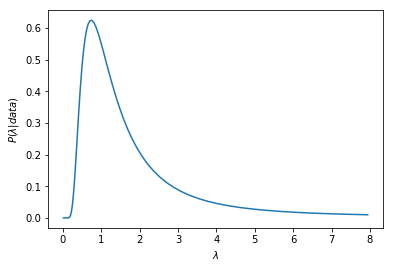

In [7]:
plt.plot(l_array, p_array/norm[0])
plt.xlabel('$\lambda$')
plt.ylabel('$P(\lambda|data)$')

In [8]:
def sample_metropolis_hastings(distro, obs_data, n_points, sigma):
    walk = np.zeros(n_points)
    walk[0] = np.random.random()*10.0
    for i in range(1,n_points):
        walk_new = np.random.normal(walk[i-1],sigma)
        p_new = distro(obs_data, np.array([walk_new]))
        p_here = distro(obs_data,np.array([walk[i-1]]))
                    
        ratio = min(1.0, p_new[0]/p_here[0])
        
        beta = np.random.random()
        if(beta < ratio and ~np.isnan(p_new[0]/p_here[0])):
            walk[i] = walk_new
        else:
            walk[i] = walk[i-1]
        if(walk[i]<0):
            print(p_new[0], p_here[0], ratio)
    return walk

In [9]:
l_walk_high_sigma = sample_metropolis_hastings(p_model_data, obs_data, 100000, 1000.0)
l_walk_low_sigma = sample_metropolis_hastings(p_model_data, obs_data, 100000, 0.001)
l_walk_mid_sigma = sample_metropolis_hastings(p_model_data, obs_data, 100000, 1.0)

/home/forero/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
def norm_hist(l_walk):
    y, x = np.histogram(l_walk, bins=50)
    x = 0.5*(x[1:]+x[:-1])
    normh = np.sum(y * (x[1]-x[0]))
    return x, y/normh

In [11]:
x_low, y_low = norm_hist(l_walk_low_sigma)
x_high, y_high = norm_hist(l_walk_high_sigma)
x_mid, y_mid = norm_hist(l_walk_mid_sigma)

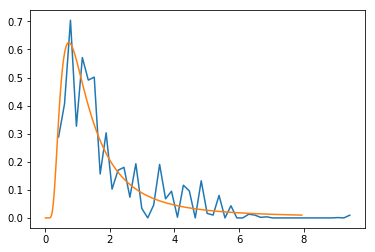

In [12]:
plt.plot(x_high ,y_high)
plt.plot(l_array, p_array/norm[0])

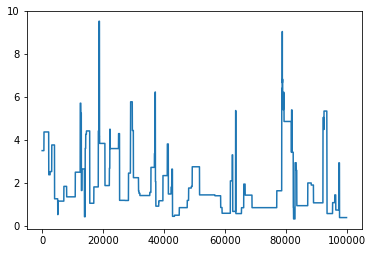

In [13]:
plt.plot(l_walk_high_sigma)

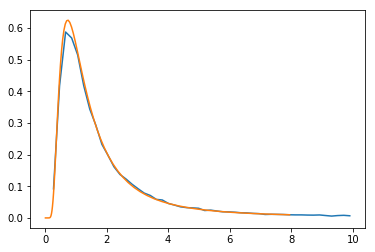

In [14]:
plt.plot(x_mid ,y_mid)
plt.plot(l_array, p_array/norm[0])

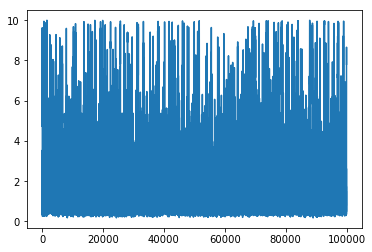

In [15]:
plt.plot(l_walk_mid_sigma)

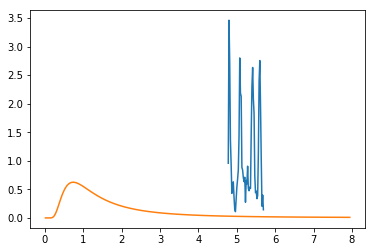

In [16]:
plt.plot(x_low ,y_low)
plt.plot(l_array, p_array/norm[0])

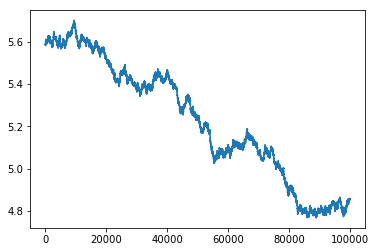

In [17]:
plt.plot(l_walk_low_sigma)

In [18]:
def gelman_rubin(distro, obs_data, N=10000, M=4, sigma=0.1):
    walks = {}
    for m in range(M):
        walks[m] = sample_metropolis_hastings(distro, obs_data, N, sigma)
    
    R = np.zeros(N-1)
    for i in range(N-1):
        n = i+1
        mean_walks = np.zeros(M)
        variance_walks = np.zeros(M)
        for m in range(M):
            mean_walks[m] = walks[m][:n].mean()
            variance_walks[m] = walks[m][:n].std() ** 2
        mean_general = mean_walks.mean()    
        B = 0.0
        for m in range(M):
            B += (mean_walks[m] - mean_general)**2
        B = n*B/(M-1)
        W = variance_walks.mean()
    
        R[n-1] = (n-1)/n + (B/W)*(M+1)/(n*M)
    
    return walks, R

In [19]:
w_high, R_high = gelman_rubin(p_model_data, obs_data, sigma=1E3)
w_low, R_low = gelman_rubin(p_model_data, obs_data, sigma=1E-3)
w_mid, R_mid = gelman_rubin(p_model_data, obs_data, sigma=1.0)

/home/forero/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/home/forero/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


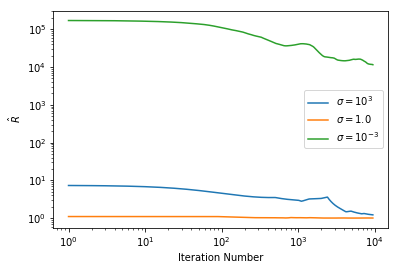

In [20]:
plt.plot(R_high[500:], label='$\sigma=10^3$')
plt.plot(R_mid[500:], label='$\sigma=1.0$')
plt.plot(R_low[500:], label='$\sigma=10^{-3}$')
plt.loglog()
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('$\hat{R}$')